In [58]:
#观察一周行为做出预测
#使用整体数据给定大体上的预测
import requests
import datetime
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.pylab import rcParams
from scipy.optimize import leastsq
from statsmodels.tsa.stattools import adfuller
import pylab as pl
import math
%matplotlib inline
rcParams['figure.figsize'] = 15, 6

def get_vip_list(s):
    data={}
    data['vip_list'] = s['id'].tolist()
    return pd.Series(data)
def to_date(s):
    dt = datetime.datetime.utcfromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d")

def func(x,p):#函数
    A,B=p
    return A*np.log(x)+B

def residuals(p,y,x):#残差
    ret =y-func(x,p)
    return ret

In [59]:
dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [{'日期': {'date_histogram': {'field': 'first_vip_created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+00:00'}}},
                                                   {'id': {'terms': {'field': 'id'}}},

                                                  ]}}},
                 'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                              'gte': '2019-03-01',
                                                              'lte': '2019-05-28',
                                                              'time_zone': '+00:00'}}}]}}}
es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res = es.search(index='es_user_table', doc_type='user', body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
df1 = json_normalize(res['aggregations']['my_buckets']['buckets'])
df1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df1.columns))
df1['日期']= df1['日期'].apply(to_date)
dts=df1.groupby('日期').apply(get_vip_list).reset_index()
GMV_all=[]
bar = progressbar
for i in bar.progressbar(range(len(dts))):
    date=dts.iloc[i]['日期']
    dsl ={'aggs': {'my_buckets': {'aggregations': {'折前GMV': {'sum': {'field': 'skutotal_price'}}},
                             'composite': {'size': 9999999,
                                           'sources': [{'日期': {'date_histogram': {'field': 'paytime',
                                                                                  'interval': '1d',
                                                                                  'time_zone': '+00:00'}}},
                                                       ]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=1))[:10],
                                                        'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=21))[:10], 
                                                         'format': 'yyyy-MM-dd', 'time_zone': '+00:00'}}}, 
                                 {'terms':{'user_id': dts.iloc[i]['vip_list']}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}]
                       }}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                    search_type='query_then_fetch')
    df = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
    GMV=[]
    for j in range(len(df)):
        GMV.append(df.iloc[j]['折前GMV.value'])
    GMV_all.append(GMV)   
dts['GMV列表'] = GMV_all

100% (89 of 89) |########################| Elapsed Time: 0:00:16 Time:  0:00:16


In [142]:
GMV_list_all=[0]*7
for i in range(len(GMV_list_all)):
    for j in range(len(dts)):
        GMV_list_all[i]=GMV_list_all[i]+dts.iloc[j]['GMV列表'][i]
        
GMV_list_ave=[0]*7
for i in range(len(GMV_list_all)):
    GMV_list_ave[i]=GMV_list_all[i]/len(dts)

#x3=np.linspace(1,22,1000) #用于画图精度的调节
x01 = []
for i in range(7):
    x01.append(i+1)
x21=np.array(x01) #向量化x变量
y01=GMV_list_ave #y
y21=np.array(y01)#向量化
p01=[1,3400]#取值起始点 

qs1=leastsq(residuals,p01,args=(y21,x21)) #最小二乘法    
    
def function_1_0(day):                     #大数据求mean()的模型   #无log
    return qs1[0][0]*np.log(day)+qs1[0][1]
qs1

(array([-508.91067477, 3285.75052695]), 1)

In [105]:
x02 = []
for i in range(7):
    x02.append(i+1)
x22=np.array(x02) #向量化x变量
y02=np.log(GMV_list_ave) #y
y22=np.array(y02)#向量化
p02=[1,3400]#取值起始点 
qs2=leastsq(residuals,p02,args=(y22,x22))

def function_1_1(day):                     #大数据求mean()的模型  #有log
    return math.e**(qs2[0][0]*np.log(day)+qs2[0][1])

function_1_1(8)

2271.309806226699

In [143]:
x33=np.linspace(1,8,1000) #用于画图精度的调节
x03=[]
for i in range(7):
    x03.append(i+1)
x03=x03*len(dts)
x23=np.array(x03) #向量化x变量
y03=[]
for i in range(len(dts)):
    y03+=dts.iloc[i]['GMV列表'][0:7]
#y0=np.log(y0) #y
y23=np.array(y03)#向量化
p03=[1,3400]#取值起始点
    
qs3=leastsq(residuals,p0,args=(y23,x23)) #最小二乘法

def function_2_0(day):                     #大数据求模型  #无log
    return qs3[0][0]*np.log(day)+qs3[0][1]

qs3

(array([-508.91066404, 3285.75051699]), 1)

In [114]:
x34=np.linspace(1,8,1000) #用于画图精度的调节
x04=[]
for i in range(7):
    x04.append(i+1)
x04=x04*len(dts)
x24=np.array(x04) #向量化x变量
y04=[]
for i in range(len(dts)):
    y04+=dts.iloc[i]['GMV列表'][0:7]
y04=np.log(y04) #y
y24=np.array(y04)#向量化
p04=[1,3400]#取值起始点
    
qs4=leastsq(residuals,p04,args=(y24,x24)) #最小二乘法

def function_2_1(day):                     #大数据求模型  #有log
    return math.e**(qs4[0][0]*np.log(day)+qs4[0][1])
function_2_1(8)

1308.9102566529648

In [158]:
GMV_list_day=[]
date_index=[]
date='2019-03-01'
for i in range(len(dts)):
    GMV_list_day.append(dts.iloc[i]['GMV列表'][7])
    date_index.append(str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=i))[:10],)

val1 = {'date_index':date_index,'value':GMV_list_day}
GMV_list=pd.DataFrame(val1)    

GMV_list['date_index']=pd.to_datetime(GMV_list['date_index'])

#x3=np.linspace(1,len(dts)+1,1000) #用于画图精度的调节

x05 = []
for i in range(len(dts)):
    x05.append(i+1)
#x0=[range(21)] #x变量, 
x25=np.array(x05) #向量化x变量
y05=GMV_list_day
y25=np.array(y05)#向量化
p05=[1,3400]#取值起始点
    
qs5=leastsq(residuals,p05,args=(y25,x25)) #最小二乘法

def function_3_0(day):                     #纵向模型  #无log
    return qs5[0][0]*np.log(day)+qs5[0][1]

function_3_0(8)

659.9265438881437

In [159]:
GMV_list_day=[]
date_index=[]
date='2019-03-01'
for i in range(len(dts)):
    GMV_list_day.append(np.log(dts.iloc[i]['GMV列表'][7]))
    date_index.append(str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=i))[:10],)

val1 = {'date_index':date_index,'value':GMV_list_day}
GMV_list=pd.DataFrame(val1)    

GMV_list['date_index']=pd.to_datetime(GMV_list['date_index'])

x36=np.linspace(1,len(dts)+1,1000) #用于画图精度的调节

x06 = []
for i in range(len(dts)):
    x06.append(i+1)
#x0=[range(21)] #x变量, 
x26=np.array(x06) #向量化x变量
y06=GMV_list_day
y26=np.array(y06)#向量化
p06=[1,3400]#取值起始点
    
qs6=leastsq(residuals,p06,args=(y26,x26)) #最小二乘法

def function_3_1(day):                     #纵向模型  #有log
    return math.e**(qs6[0][0]*np.log(day)+qs6[0][1])
function_3_1(8)

433.35112258541915

验证准确度

In [166]:
dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [{'日期': {'date_histogram': {'field': 'first_vip_created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+00:00'}}},
                                                   {'id': {'terms': {'field': 'id'}}},

                                                  ]}}},
                 'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                              'gte': '2019-04-01',
                                                              'lte': '2019-06-01',
                                                              'time_zone': '+00:00'}}}]}}}
es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res = es.search(index='es_user_table', doc_type='user', body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
df1 = json_normalize(res['aggregations']['my_buckets']['buckets'])
df1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df1.columns))
df1['日期']= df1['日期'].apply(to_date)
dts1=df1.groupby('日期').apply(get_vip_list).reset_index()

In [167]:
date='2019-04-09'
GMV_list=[]
for i in range(len(dts1)):
    dsl ={'aggs': {'my_buckets': {'aggregations': {'折前GMV': {'sum': {'field': 'skutotal_price'}}},
                             'composite': {'size': 9999999,
                                           'sources': [{'日期': {'date_histogram': {'field': 'paytime',
                                                                                  'interval': '1d',
                                                                                  'time_zone': '+00:00'}}},
                                                       ]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=i))[:10],
                                                        'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=i))[:10], 
                                                         'format': 'yyyy-MM-dd', 'time_zone': '+00:00'}}}, 
                                 {'terms':{'user_id': dts1.iloc[i]['vip_list']}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}]
                       }}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                    search_type='query_then_fetch')
    df = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
    GMV_list.append(df.iloc[0]['折前GMV.value'])

In [162]:
dts1['实际GMV']=GMV_list

In [163]:
day=8
function_1=[]
function_2=[]
function_3=[]
function_4=[]
function_5=[]
function_6=[]
for i in range(len(dts1)):
    function_1.append((dts1.iloc[i]['实际GMV']-function_1_0(day))/dts1.iloc[i]['实际GMV'])
    function_2.append((dts1.iloc[i]['实际GMV']-function_1_1(day))/dts1.iloc[i]['实际GMV'])
    function_3.append((dts1.iloc[i]['实际GMV']-function_2_0(day))/dts1.iloc[i]['实际GMV'])
    function_4.append((dts1.iloc[i]['实际GMV']-function_2_1(day))/dts1.iloc[i]['实际GMV'])
    function_5.append((dts1.iloc[i]['实际GMV']-function_3_0(day))/dts1.iloc[i]['实际GMV'])
    function_6.append((dts1.iloc[i]['实际GMV']-function_3_1(day))/dts1.iloc[i]['实际GMV'])

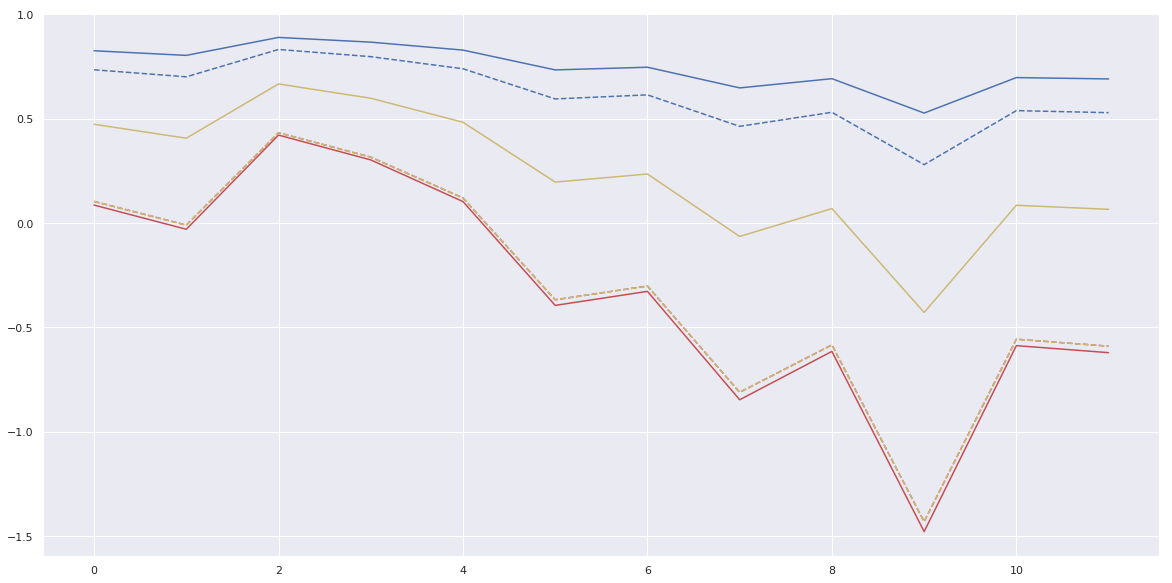

In [164]:
f,ax = plt.subplots(figsize = (20,10))
plt.plot(function_1,'r--')
plt.plot(function_2,'r-')
plt.plot(function_3,'y--')
plt.plot(function_4,'y-')
plt.plot(function_5,'b--')
plt.plot(function_6,'b-')

In [56]:
function_3_1(day)

62.66484179314177

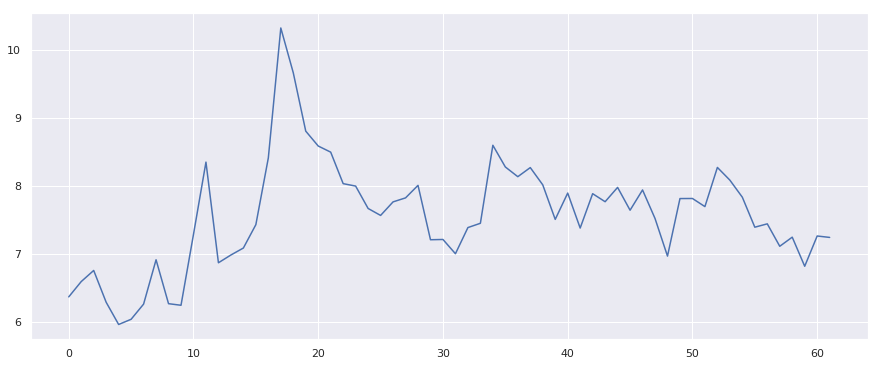

In [157]:
plt.plot(np.log(dts1['实际GMV']))

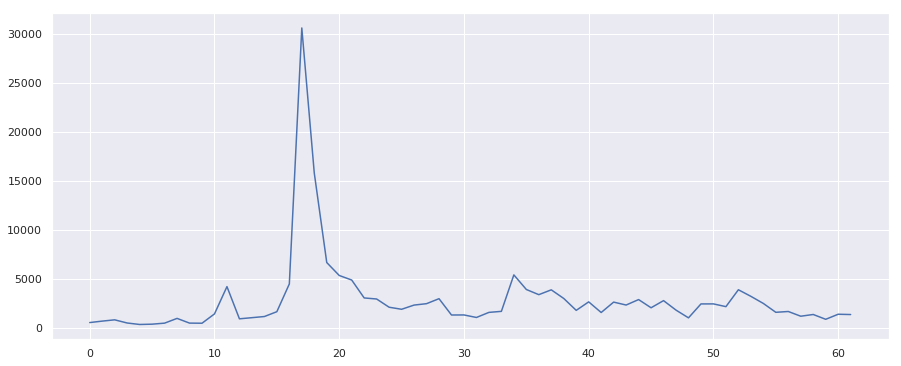

In [169]:
plt.plot(GMV_list)